<a href="https://colab.research.google.com/github/Rakshna2002/Telecom-Churn-Analysis/blob/main/Telecom_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

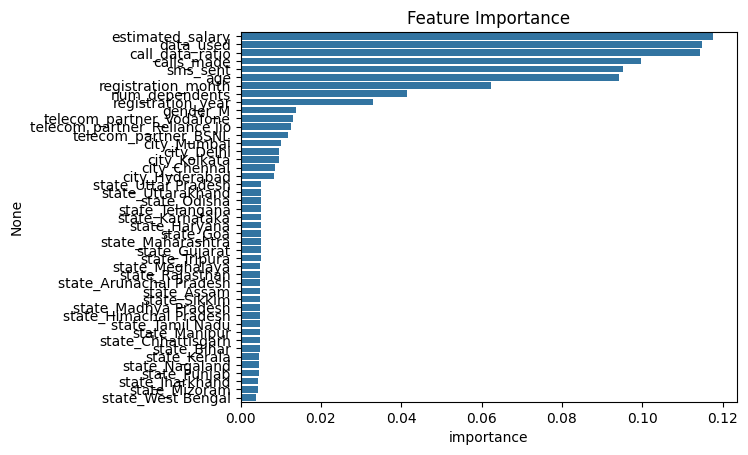

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     38928
           1       0.00      0.00      0.00      9783

    accuracy                           0.80     48711
   macro avg       0.40      0.50      0.44     48711
weighted avg       0.64      0.80      0.71     48711

Accuracy: 0.7992
AUC-ROC: 0.4989


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_data(file_path):
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
        df.dropna(inplace=True)
        df['date_of_registration'] = pd.to_datetime(df['date_of_registration'])
        return df
    except Exception as e:
        print(f"Error loading Excel file: {e}")
        return None

def feature_engineering(df):
    if 'calls_made' in df.columns and 'data_used' in df.columns:
        df['call_data_ratio'] = df['calls_made'] / (df['data_used'] + 1)  # Add 1 to avoid division by zero

        df['registration_year'] = df['date_of_registration'].dt.year
        df['registration_month'] = df['date_of_registration'].dt.month

        df = pd.get_dummies(df, columns=['telecom_partner', 'gender', 'state', 'city'], drop_first=True)

        df.drop(['customer_id', 'pincode', 'date_of_registration'], axis=1, inplace=True)
    else:
        print("Error: Required columns not found in DataFrame.")
    return df

def build_and_train_model(df):
    if 'churn' in df.columns:
        X = df.drop('churn', axis=1)
        y = df['churn']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model = RandomForestClassifier(random_state=42, n_jobs=-1)  # Utilize all available cores
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        return model, X_test, y_test, y_pred, y_prob
    else:
        print("Error: 'churn' column not found in DataFrame.")
        return None, None, None, None, None

def interpret_model(model, X):
    if model is not None:
        feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
        feature_importances = feature_importances.sort_values('importance', ascending=False)
        sns.barplot(x=feature_importances['importance'], y=feature_importances.index)
        plt.title('Feature Importance')
        plt.show()
        return feature_importances
    else:
        print("Error: Model is None, cannot interpret.")
        return None

def evaluate_model(y_test, y_pred, y_prob):
    if y_test is not None and y_pred is not None and y_prob is not None:
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")
    else:
        print("Error: Evaluation data is None, cannot evaluate.")

if __name__ == "__main__":
    file_path = 'telecom_churn.xlsx'  # Ensure the file path matches the uploaded file

    df = load_and_preprocess_data(file_path)

    if df is not None:
        # Feature engineering
        df = feature_engineering(df)

        model, X_test, y_test, y_pred, y_prob = build_and_train_model(df)

        if model is not None and X_test is not None and y_test is not None and y_pred is not None and y_prob is not None:
            interpret_model(model, pd.DataFrame(X_test, columns=df.drop('churn', axis=1).columns))

            evaluate_model(y_test, y_pred, y_prob)
